In [1]:
import pandas as pd
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from AntennaUtils import *  

# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)

In [2]:
# RT32 location (Ventspils, Latvia)
rt32_antenna = RT32()
rt32_antenna.set_location(latitude=57.5535171694, longitude=21.8545525000, elevation=20)

# Define constants
path = ''
year = 2024
month = 2
day = 15
hour_start = 11
minute_start = 25

observation = SpiralSunObservation(rt32_antenna , year , month , day , hour_start , minute_start)

az_anten, el_anten , az_sun , el_sun , xx1 , yy1, utc = observation.calculatePositions()
observation.generateFile(path, az_anten , el_anten , utc)  

-------------------------------------------------------------
Saved:  sun_scan_240215_1125.ptf    3300   points


True

In [3]:
# Create DataFrame
sunPositionDf = pd.DataFrame({'UTC': utc,'SunX': xx1, 'SunY': yy1})

print(sunPositionDf.describe())


fit_file_path = "test2.fit"
hdu_number = 1  # Número de la extensión que contiene la tabla binaria

# Convierte la tabla binaria a un DataFrame de Pandas
data_df = bintable_to_pandas(fit_file_path, hdu_number)

print(data_df.describe())


                     UTC            SunX            SunY
count    3300.0000000000 3300.0000000000 3300.0000000000
mean  2460355.9947858797   -0.0017625327    0.0038110040
std         0.0110274568   20.6919640052   20.6895363325
min   2460355.9756944445  -60.4283809552  -63.9858262570
25%   2460355.9852401619   -9.9948465036  -11.6146297392
50%   2460355.9947858797    0.0000000000    0.0000000000
75%   2460356.0043315976    9.8611902539    9.9619275488
max   2460356.0138773150   61.3145328782   52.6190360953


        LCP 01 4.07GHZ   LCP 04 6.42GHZ   LCP 07 8.40GHZ   LCP 09 9.80GHZ  \
count  1872.0000000000  1872.0000000000  1872.0000000000  1872.0000000000   
mean  17737.5219017094 21194.8723290598 22459.6447649573 22921.1447649573   
std     469.8873997180   305.0346367262   171.8903587763   108.9282116868   
min   17285.0000000000 20890.0000000000 22280.0000000000 22808.0000000000   
25%   17340.0000000000 20929.0000000000 22305.0000000000 22827.0000000000   
50%   17527.5000000000 21060.0000000000 22379.5000000000 22871.0000000000   
75%   18074.0000000000 21475.0000000000 22646.0000000000 23035.0000000000   
max   19696.0000000000 22710.0000000000 23241.0000000000 23863.0000000000   

       LCP 11 11.90GHZ   RCP 01 4.07GHZ   RCP 04 6.42GHZ   RCP 07 8.40GHZ  \
count  1872.0000000000  1872.0000000000  1872.0000000000  1872.0000000000   
mean  15044.6848290598 17459.1901709402 22618.7986111111 21558.5325854701   
std     108.6849335361   517.6658030473   306.4793905360   189.3222038039  

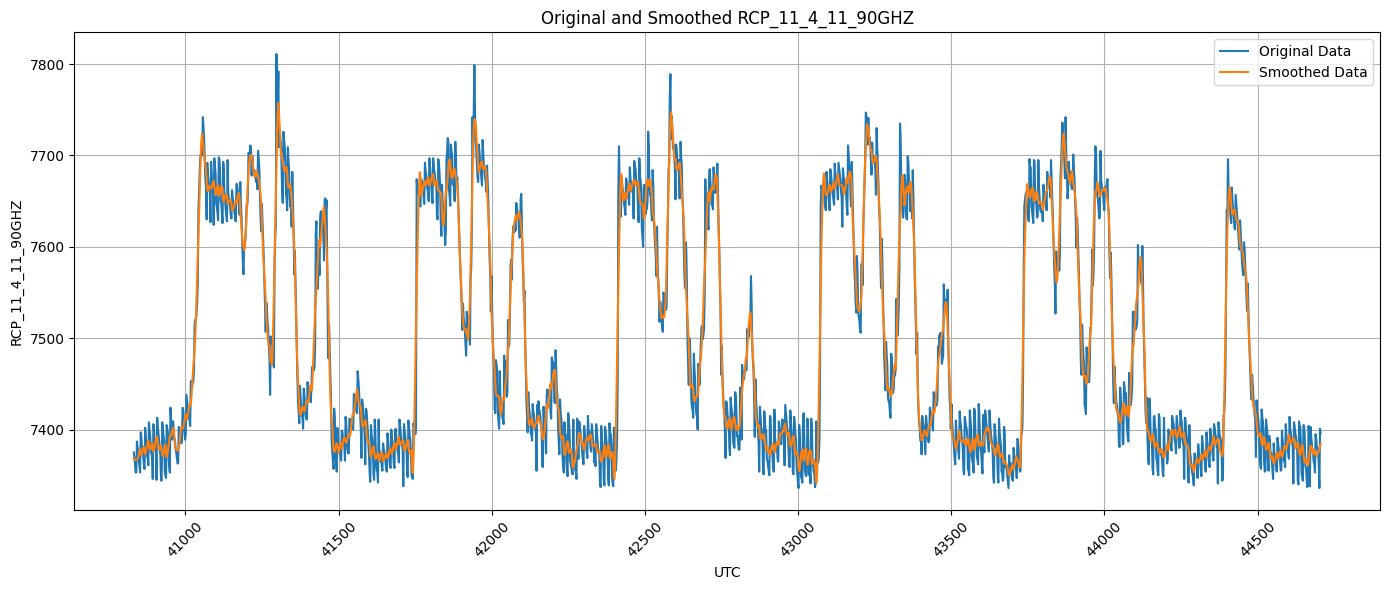

In [4]:
RCP_11_df = processData(data_df)

# Plotting both original and smoothed data
plt.figure(figsize=(14, 6))
plt.plot(RCP_11_df['UTC_RCP_11'], RCP_11_df['RCP_11_4_11_90GHZ'], label='Original Data', linestyle='-')
plt.plot(RCP_11_df['UTC_RCP_11'], RCP_11_df['Filtered_RCP_11_4_11_90GHZ'], label='Smoothed Data', linestyle='-')
plt.xlabel('UTC')
plt.ylabel('RCP_11_4_11_90GHZ')
plt.title('Original and Smoothed RCP_11_4_11_90GHZ')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
rest_of_df = getFinalProcessedData(observation , sunPositionDf,RCP_11_df)

Interpolating data...
Filtering data...
Calibrating data...


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['RCP_11_4_11_90GHZ'] = (rest_of_df['RCP_11_4_11_90GHZ'] - min_vect[0]) / (max_vect[0] - min_vect[0])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['Filtered_RCP_11_4_11_90GHZ'] = (rest_of_df['Filtered_RCP_11_4_11_90GHZ'] - min_vect[1]) / (max_vect[1] - min_vect[1])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:420: S

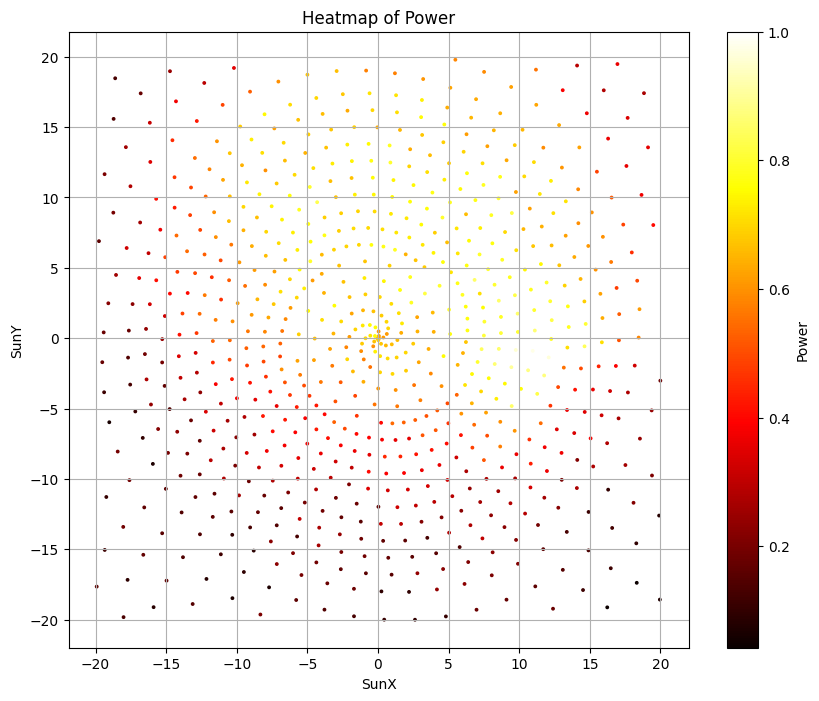

In [14]:
# Crear el heatmap
plt.figure(figsize=(10, 8))
plt.scatter(rest_of_df['SunX'], rest_of_df['SunY'], c=rest_of_df['RCP_11_4_11_90GHZ'], cmap='hot',s=3)
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap of Power')
plt.grid(True)  # Mostrar la cuadrícula para mayor claridad
plt.show()

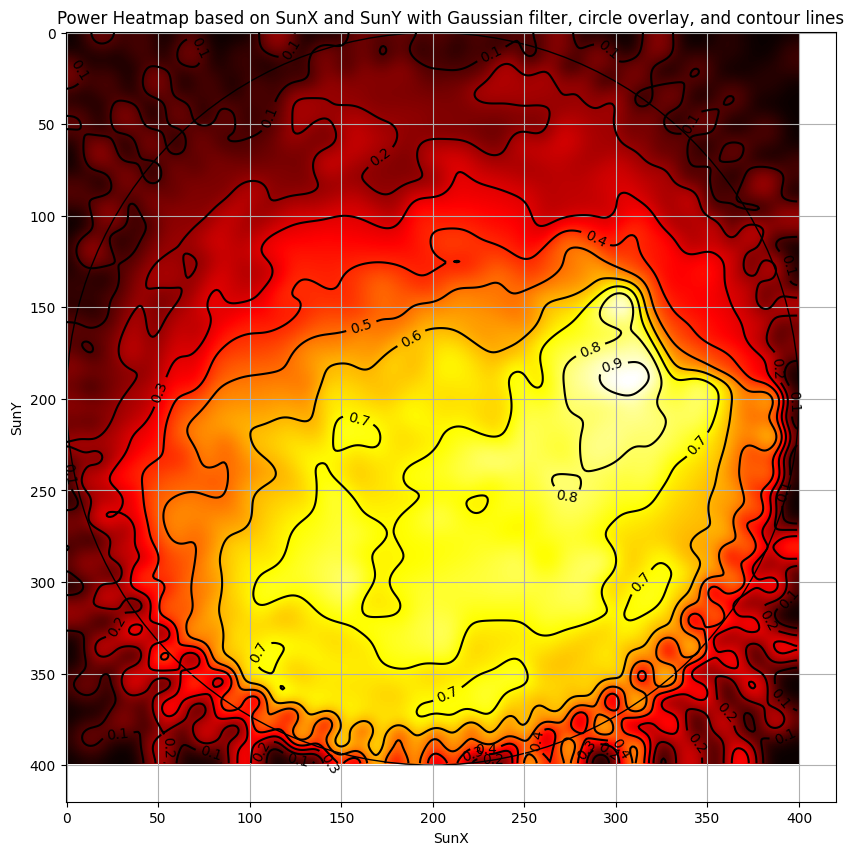

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle

# Sample data
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = rest_of_df['RCP_11_4_11_90GHZ']

# Define grid size and point radius
grid_size = 400
point_radius = 10

# Calculate scale to convert SunX and SunY coordinates to matrix indices
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Create matrices for power and counts of points in each cell
Z = np.zeros((grid_size, grid_size))
counts = np.zeros((grid_size, grid_size))

# Iterate over each point and expand its power value in matrix Z
for x, y, power in zip(SunX, SunY, Power):
    i = int((x - x_min) / x_range * (grid_size - 1))
    j = int((y - y_min) / y_range * (grid_size - 1))
    
    y_indices, x_indices = np.ogrid[-j:grid_size-j, -i:grid_size-i]
    distances = np.sqrt(x_indices**2 + y_indices**2)
    
    indices_within_radius = np.where(distances <= point_radius)
    
    Z[indices_within_radius] += power
    counts[indices_within_radius] += 1

Z[counts > 0] /= counts[counts > 0]

# Apply Gaussian filter to matrix Z
Z_smoothed = gaussian_filter(Z, sigma=5)

# Create figure and axes
plt.figure(figsize=(10, 10))

# Plot smoothed heatmap
plt.imshow(Z_smoothed, cmap='hot')

# Overlay a circle with center and radius of 200 pixels
circle = Circle((grid_size // 2, grid_size // 2), radius=200, edgecolor='black', facecolor='none')
plt.gca().add_patch(circle)

# Add contour lines at values rounded to 0.1, 0.2, ..., 0.9
levels = np.arange(0.1, 1.0, 0.1)
contours = plt.contour(Z_smoothed, levels=levels, colors='black')

# Label the contours
plt.clabel(contours, inline=True, fmt='%.1f', fontsize=10)

# Adjust labels and title
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Power Heatmap based on SunX and SunY with Gaussian filter, circle overlay, and contour lines')

# Show grid
plt.grid(True)

# Show the plot
plt.show()


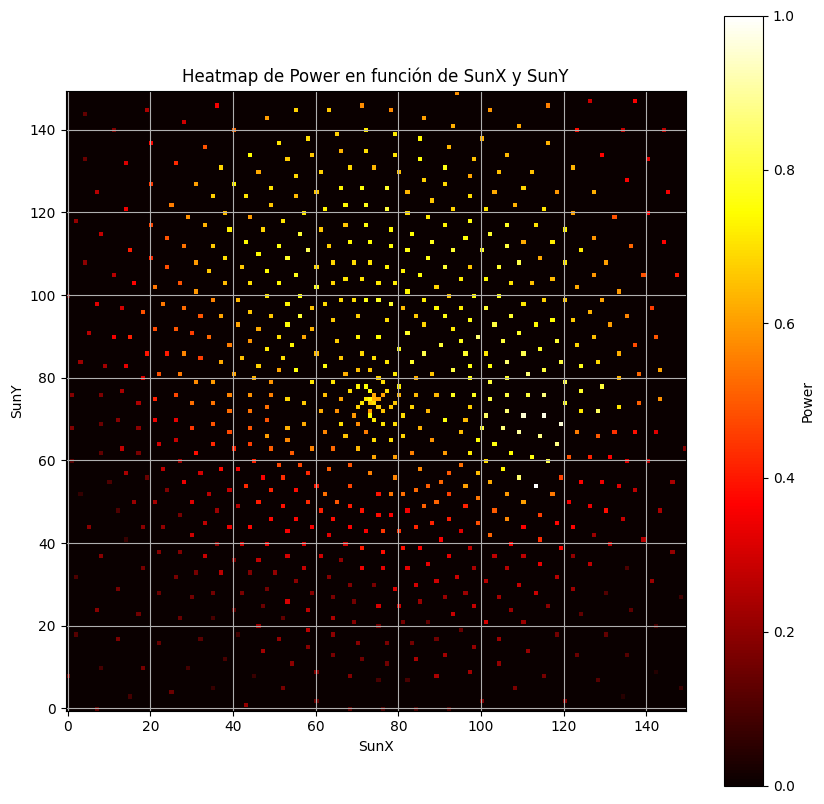

In [7]:
# Datos de ejemplo
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = rest_of_df['RCP_11_4_11_90GHZ']

# Definir el tamaño de la cuadrícula y crear una matriz de ceros
grid_size = 400
grid_power = np.zeros((grid_size, grid_size))

# Calcular la escala para convertir las coordenadas SunX y SunY en índices de matriz
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Convertir las coordenadas SunX y SunY en índices de matriz
grid_x_index = ((SunX - x_min) / x_range * (grid_size - 1)).astype(int)
grid_y_index = ((SunY - y_min) / y_range * (grid_size - 1)).astype(int)

# Asignar valores de Power a la matriz en las posiciones correspondientes
grid_power[grid_y_index, grid_x_index] = Power

# Mostrar la imagen
plt.figure(figsize=(10, 10))
plt.imshow(grid_power, cmap='hot', origin='lower')
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap de Power en función de SunX y SunY')
plt.grid(True)  # Mostrar la cuadrícula para mayor claridad
plt.show()


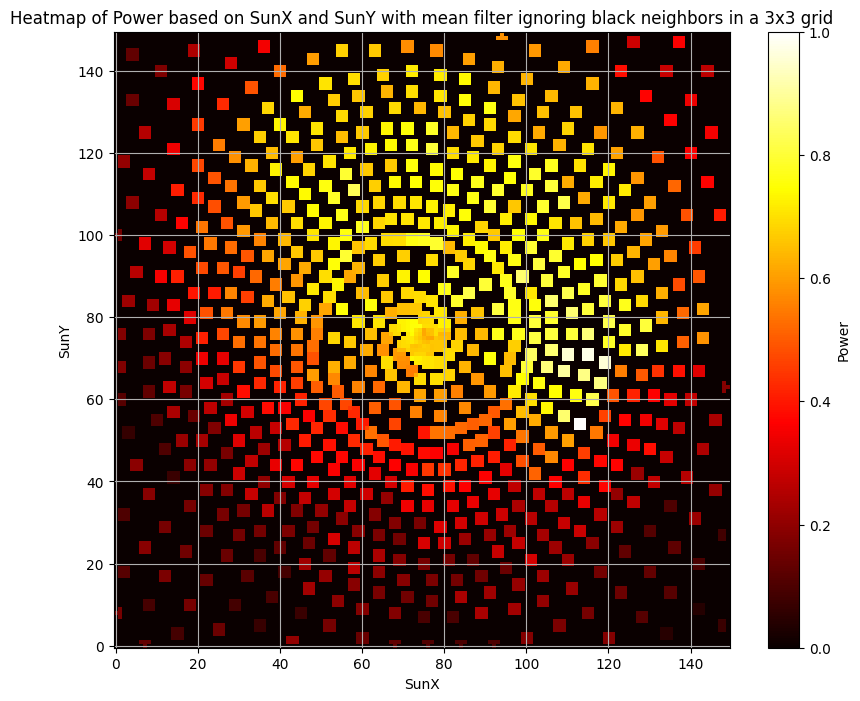

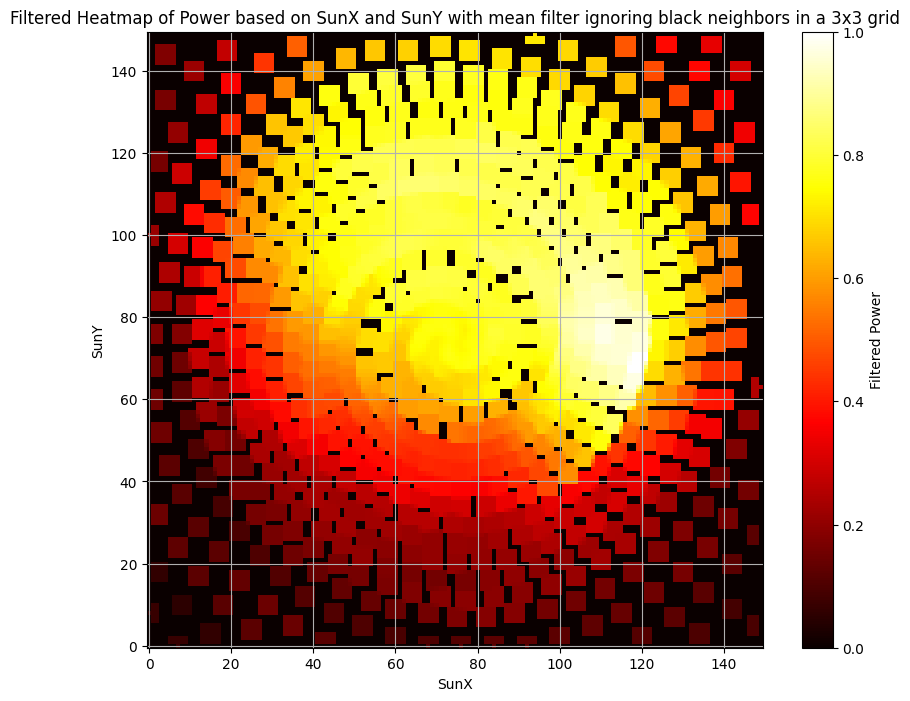

In [8]:
# Define a function to apply the mean filter ignoring black neighbors in a 3x3 grid
def apply_mean_filter_ignore_black(image):
    y, x = image.shape
    new_image = image.copy()
    for i in range(1, y - 1):
        for j in range(1, x - 1):           
            neighbors = image[i-1:i+2, j-1:j+2]
            non_zero_neighbors = neighbors[neighbors > 0]
            if non_zero_neighbors.size > 0:
                new_image[i, j] = np.mean(non_zero_neighbors)
    return new_image

# Example data
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = rest_of_df['RCP_11_4_11_90GHZ']
PowerFilter = rest_of_df['Filtered_RCP_11_4_11_90GHZ']

# Define the grid size and create a matrix of zeros
grid_size = 150
grid_power = np.zeros((grid_size, grid_size))
grid_power_filter = np.zeros((grid_size, grid_size))

# Calculate the scale to convert SunX and SunY coordinates into matrix indices
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Convert SunX and SunY coordinates into matrix indices
grid_x_index = ((SunX - x_min) / x_range * (grid_size - 1)).astype(int)
grid_y_index = ((SunY - y_min) / y_range * (grid_size - 1)).astype(int)

# Assign Power values to the matrix at the corresponding positions
grid_power[grid_y_index, grid_x_index] = Power
grid_power_filter[grid_y_index, grid_x_index] = PowerFilter

# Apply mean filter ignoring black neighbors in a 3x3 grid
filtered_image = apply_mean_filter_ignore_black(grid_power)


filtered_image_filter = apply_mean_filter_ignore_black(grid_power_filter)
filtered_image_filter = apply_mean_filter_ignore_black(filtered_image_filter)
# Plot the original image
plt.figure(figsize=(10, 8))
plt.imshow(filtered_image, cmap='hot', origin='lower')
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap of Power based on SunX and SunY with mean filter ignoring black neighbors in a 3x3 grid')
plt.grid(True)  # Show grid for clarity
plt.show()

# Plot the filtered image
plt.figure(figsize=(10, 8))
plt.imshow(filtered_image_filter, cmap='hot', origin='lower')
plt.colorbar(label='Filtered Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Filtered Heatmap of Power based on SunX and SunY with mean filter ignoring black neighbors in a 3x3 grid')
plt.grid(True)  # Show grid for clarity
plt.show()
